In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [14]:
import numpy as np
import pandas as pd
import random
from typing import List, Tuple

# Load the data
df = pd.read_csv("/kaggle/input/data-stock/Data.csv")
stock_data = df[['Open', 'Close', 'High', 'Low']].values.tolist()

# Define the Rule class
class Rule:
    def __init__(self, condition, action):
        self.condition = condition
        self.action = action

    def evaluate(self, state):
        return self.condition(state)

# Define the Agent class
class Agent:
    def __init__(self, num_rules):
        self.rules = self.generate_random_rules(num_rules)
        self.wealth = 1000 + random.uniform(-100, 100)  # Random initial wealth
        self.stocks = 0  # Initial stock holdings

    def generate_random_rules(self, num_rules):
        rules = []
        for _ in range(num_rules):
            rule_type = random.choice(['moving_average', 'price_change', 'bollinger_bands'])
            if rule_type == 'moving_average':
                short_period = random.randint(5, 15)  # Shorter windows
                long_period = random.randint(16, 40)
                threshold = random.uniform(0.01, 0.03)  # Lower threshold for sensitivity
                condition = lambda state: self.moving_average_crossover(state, short_period, long_period, threshold)
            elif rule_type == 'price_change':
                threshold = random.uniform(0.01, 0.05)  # Lower threshold
                condition = lambda state: self.price_change(state, threshold)
            elif rule_type == 'bollinger_bands':
                period = random.randint(10, 20)
                std_dev = random.uniform(1.5, 2)
                condition = lambda state: self.bollinger_bands(state, period, std_dev)
            
            action = random.choice(['buy', 'sell', 'hold'])
            rules.append(Rule(condition, action))
        return rules

    def make_decision(self, state):
        for rule in self.rules:
            if rule.evaluate(state):
                return rule.action
        return 'hold'  # Default action if no rule matches

    def moving_average_crossover(self, state, short_period, long_period, threshold):
        if len(state) < long_period:
            return False
        short_ma = np.mean([s[1] for s in state[-short_period:]])  # Use 'Close' price
        long_ma = np.mean([s[1] for s in state[-long_period:]])  # Use 'Close' price
        return abs(short_ma - long_ma) / long_ma > threshold

    def price_change(self, state, threshold):
        if len(state) < 2:
            return False
        return abs(state[-1][1] - state[-2][1]) / state[-2][1] > threshold  # Comparing 'Close' prices

    def bollinger_bands(self, state, period, std_dev):
        if len(state) < period:
            return False
        prices = [s[1] for s in state[-period:]]  # Use 'Close' price
        ma = np.mean(prices)
        std = np.std(prices)
        upper_band = ma + std_dev * std
        lower_band = ma - std_dev * std
        return state[-1][1] > upper_band or state[-1][1] < lower_band

# Define the Simulation class
class Simulation:
    def __init__(self, num_agents, num_rules, stock_data):
        self.agents = [Agent(num_rules) for _ in range(num_agents)]
        self.stock_data = stock_data
        self.current_day = 0

    def run(self, num_days):
        for _ in range(num_days):
            state = self.stock_data[:self.current_day + 1]  # Stock data up to current day
            for agent in self.agents:
                decision = agent.make_decision(state)
                self.execute_trade(agent, decision, state)
            self.current_day += 1

    def execute_trade(self, agent, decision, state):
        current_price = state[-1][1]  # 'Close' price
        if decision == 'buy' and agent.wealth >= current_price:
            agent.stocks += 1
            agent.wealth -= current_price
        elif decision == 'sell' and agent.stocks > 0:
            agent.stocks -= 1
            agent.wealth += current_price

    def evolve(self):
        # Evolution logic: keep top-performing agents and mutate them
        sorted_agents = sorted(self.agents, key=lambda x: x.wealth, reverse=True)
        top_half = sorted_agents[:len(sorted_agents)//2]
        new_agents = []
        for agent in top_half:
            new_agent = Agent(len(agent.rules))
            new_agent.rules = agent.rules  # Inherit rules
            new_agents.append(new_agent)

        # Mutation: randomly adjust some rules
        for agent in new_agents:
            if random.random() < 0.1:  # 10% chance to mutate
                agent.rules = self.mutate_rules(agent.rules)

        self.agents = new_agents * 2  # Repopulate the agent pool

    def mutate_rules(self, rules):
        for rule in rules:
            if random.random() < 0.3:  # 30% chance to mutate each rule
                rule.action = random.choice(['buy', 'sell', 'hold'])  # Change action
        return rules

# Run the simulation
num_agents = 100
num_rules = 5  # Each agent now has 5 rules
num_generations = 50
days_per_generation = 5

sim = Simulation(num_agents, num_rules, stock_data)

for generation in range(num_generations):
    print(f"Generation {generation + 1}")
    sim.run(days_per_generation)
    
    # Calculate and print statistics
    wealths = [agent.wealth for agent in sim.agents]
    avg_wealth = sum(wealths) / len(wealths)
    max_wealth = max(wealths)
    min_wealth = min(wealths)
    print(f"Average wealth: {avg_wealth:.2f}")
    print(f"Max wealth: {max_wealth:.2f}")
    print(f"Min wealth: {min_wealth:.2f}")
    
    sim.evolve()

# Print final results
print("\nFinal Results:")
wealths = [agent.wealth for agent in sim.agents]
avg_wealth = sum(wealths) / len(wealths)
max_wealth = max(wealths)
min_wealth = min(wealths)
print(f"Average wealth: {avg_wealth:.2f}")
print(f"Max wealth: {max_wealth:.2f}")
print(f"Min wealth: {min_wealth:.2f}")


Generation 1
Average wealth: 996.71
Max wealth: 1099.66
Min wealth: 902.70
Generation 2
Average wealth: 992.49
Max wealth: 1085.46
Min wealth: 902.98
Generation 3
Average wealth: 990.34
Max wealth: 1082.85
Min wealth: 900.96
Generation 4
Average wealth: 997.91
Max wealth: 1095.27
Min wealth: 900.86
Generation 5
Average wealth: 1004.70
Max wealth: 1097.13
Min wealth: 908.03
Generation 6
Average wealth: 988.36
Max wealth: 1097.28
Min wealth: 901.56
Generation 7
Average wealth: 992.54
Max wealth: 1097.81
Min wealth: 901.00
Generation 8
Average wealth: 991.93
Max wealth: 1090.31
Min wealth: 900.45
Generation 9
Average wealth: 989.47
Max wealth: 1098.80
Min wealth: 901.29
Generation 10
Average wealth: 996.21
Max wealth: 1097.79
Min wealth: 900.51
Generation 11
Average wealth: 996.20
Max wealth: 1099.55
Min wealth: 900.90
Generation 12
Average wealth: 1000.82
Max wealth: 1096.18
Min wealth: 900.79
Generation 13
Average wealth: 1011.37
Max wealth: 1091.61
Min wealth: 917.80
Generation 14
Aver

Generation 1
Average wealth: 988.26
Max wealth: 1030.76
Min wealth: 904.13
Generation 2
Average wealth: 1024.74
Max wealth: 1024.74
Min wealth: 1024.74
Generation 3
Average wealth: 942.38
Max wealth: 942.38
Min wealth: 942.38
Generation 4
Average wealth: 1020.12
Max wealth: 1020.12
Min wealth: 1020.12
Generation 5
Average wealth: 1057.96
Max wealth: 1057.96
Min wealth: 1057.96
Generation 6
Average wealth: 1056.49
Max wealth: 1056.49
Min wealth: 1056.49
Generation 7
Average wealth: 1020.05
Max wealth: 1020.05
Min wealth: 1020.05
Generation 8
Average wealth: 1020.43
Max wealth: 1020.43
Min wealth: 1020.43
Generation 9
Average wealth: 1069.52
Max wealth: 1069.52
Min wealth: 1069.52
Generation 10
Average wealth: 1095.26
Max wealth: 1095.26
Min wealth: 1095.26
Generation 11
Average wealth: 1035.92
Max wealth: 1035.92
Min wealth: 1035.92
Generation 12
Average wealth: 1072.54
Max wealth: 1072.54
Min wealth: 1072.54
Generation 13
Average wealth: 939.32
Max wealth: 939.32
Min wealth: 939.32
Gen

<Figure size 1500x500 with 0 Axes>

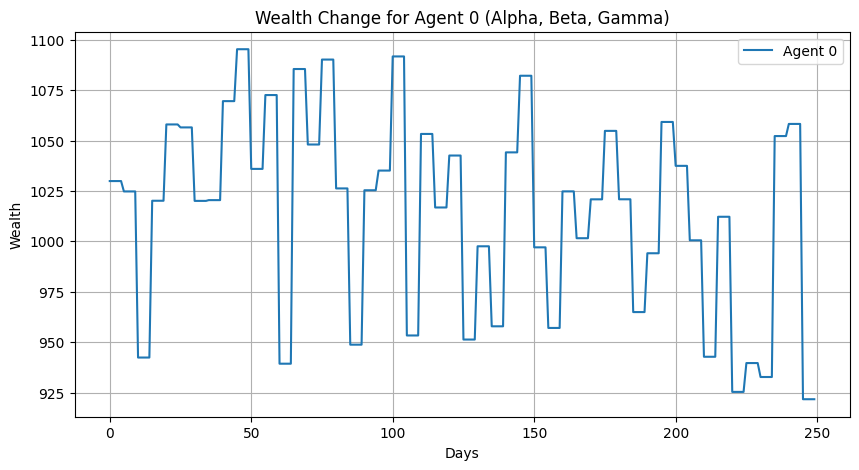

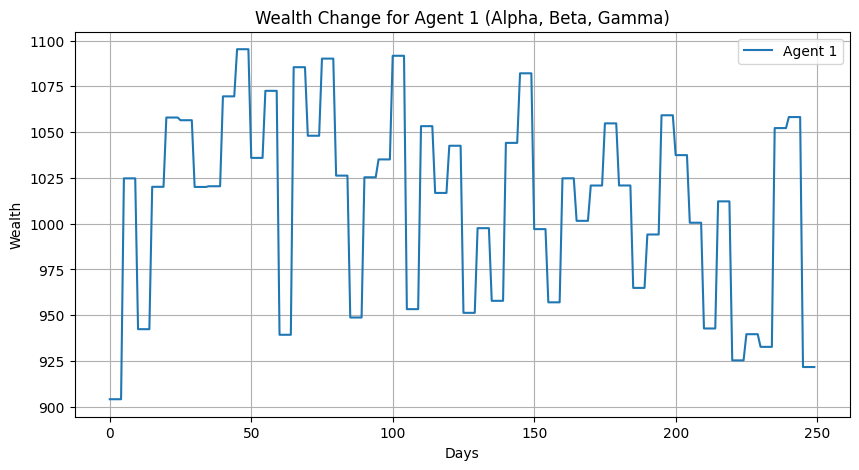

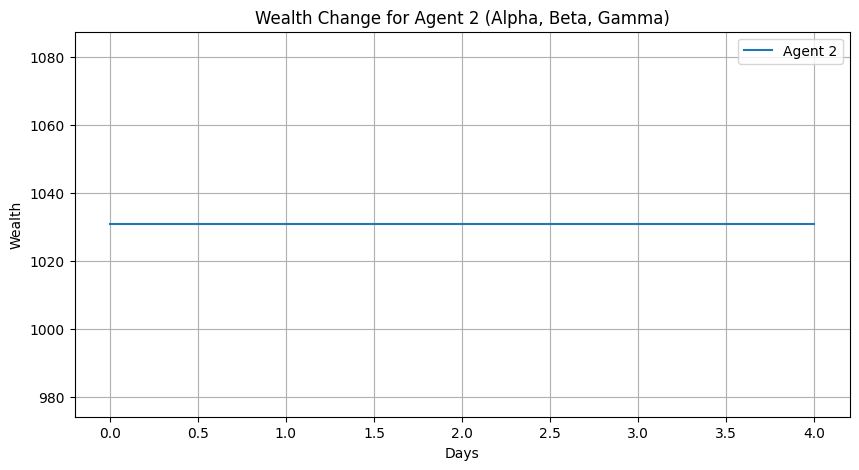

In [15]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from typing import List

# Load the data
df = pd.read_csv("/kaggle/input/data-stock/Data.csv")
stock_data = df[['Open', 'Close', 'High', 'Low']].values.tolist()

# Define the Rule class
class Rule:
    def __init__(self, condition, action):
        self.condition = condition
        self.action = action

    def evaluate(self, state):
        return self.condition(state)

# Define the Agent class
class Agent:
    def __init__(self, num_rules):
        self.rules = self.generate_random_rules(num_rules)
        self.wealth = 1000 + random.uniform(-100, 100)  # Random initial wealth
        self.stocks = 0  # Initial stock holdings

    def generate_random_rules(self, num_rules):
        rules = []
        for _ in range(num_rules):
            rule_type = random.choice(['moving_average', 'price_change', 'bollinger_bands'])
            if rule_type == 'moving_average':
                short_period = random.randint(5, 15)  # Shorter windows
                long_period = random.randint(16, 40)
                threshold = random.uniform(0.01, 0.03)  # Lower threshold for sensitivity
                condition = lambda state: self.moving_average_crossover(state, short_period, long_period, threshold)
            elif rule_type == 'price_change':
                threshold = random.uniform(0.01, 0.05)  # Lower threshold
                condition = lambda state: self.price_change(state, threshold)
            elif rule_type == 'bollinger_bands':
                period = random.randint(10, 20)
                std_dev = random.uniform(1.5, 2)
                condition = lambda state: self.bollinger_bands(state, period, std_dev)
            
            action = random.choice(['buy', 'sell', 'hold'])
            rules.append(Rule(condition, action))
        return rules

    def make_decision(self, state):
        for rule in self.rules:
            if rule.evaluate(state):
                return rule.action
        return 'hold'  # Default action if no rule matches

    def moving_average_crossover(self, state, short_period, long_period, threshold):
        if len(state) < long_period:
            return False
        short_ma = np.mean([s[1] for s in state[-short_period:]])  # Use 'Close' price
        long_ma = np.mean([s[1] for s in state[-long_period:]])  # Use 'Close' price
        return abs(short_ma - long_ma) / long_ma > threshold

    def price_change(self, state, threshold):
        if len(state) < 2:
            return False
        return abs(state[-1][1] - state[-2][1]) / state[-2][1] > threshold  # Comparing 'Close' prices

    def bollinger_bands(self, state, period, std_dev):
        if len(state) < period:
            return False
        prices = [s[1] for s in state[-period:]]  # Use 'Close' price
        ma = np.mean(prices)
        std = np.std(prices)
        upper_band = ma + std_dev * std
        lower_band = ma - std_dev * std
        return state[-1][1] > upper_band or state[-1][1] < lower_band

# Define the Simulation class
class Simulation:
    def __init__(self, num_agents, num_rules, stock_data):
        self.agents = [Agent(num_rules) for _ in range(num_agents)]
        self.stock_data = stock_data
        self.current_day = 0
        self.wealth_history = [[] for _ in range(num_agents)]  # Track wealth over time

    def run(self, num_days):
        for _ in range(num_days):
            state = self.stock_data[:self.current_day + 1]  # Stock data up to current day
            for idx, agent in enumerate(self.agents):
                decision = agent.make_decision(state)
                self.execute_trade(agent, decision, state)
                self.wealth_history[idx].append(agent.wealth)  # Store wealth after each day
            self.current_day += 1

    def execute_trade(self, agent, decision, state):
        current_price = state[-1][1]  # 'Close' price
        if decision == 'buy' and agent.wealth >= current_price:
            agent.stocks += 1
            agent.wealth -= current_price
        elif decision == 'sell' and agent.stocks > 0:
            agent.stocks -= 1
            agent.wealth += current_price

    def evolve(self):
        # Evolution logic: keep top-performing agents and mutate them
        sorted_agents = sorted(self.agents, key=lambda x: x.wealth, reverse=True)
        top_half = sorted_agents[:len(sorted_agents)//2]
        new_agents = []
        for agent in top_half:
            new_agent = Agent(len(agent.rules))
            new_agent.rules = agent.rules  # Inherit rules
            new_agents.append(new_agent)

        # Mutation: randomly adjust some rules
        for agent in new_agents:
            if random.random() < 0.1:  # 10% chance to mutate
                agent.rules = self.mutate_rules(agent.rules)

        self.agents = new_agents * 2  # Repopulate the agent pool

    def mutate_rules(self, rules):
        for rule in rules:
            if random.random() < 0.3:  # 30% chance to mutate each rule
                rule.action = random.choice(['buy', 'sell', 'hold'])  # Change action
        return rules

# Run the simulation with 3 agents
num_agents = 3  # Only Alpha, Beta, and Gamma
num_rules = 5  # Each agent has 5 rules
num_generations = 50
days_per_generation = 5

sim = Simulation(num_agents, num_rules, stock_data)

# Create a figure for wealth changes
plt.figure(figsize=(15, 5))

for generation in range(num_generations):
    print(f"Generation {generation + 1}")
    sim.run(days_per_generation)

    # Calculate and print statistics
    wealths = [agent.wealth for agent in sim.agents]
    avg_wealth = sum(wealths) / len(wealths)
    max_wealth = max(wealths)
    min_wealth = min(wealths)
    print(f"Average wealth: {avg_wealth:.2f}")
    print(f"Max wealth: {max_wealth:.2f}")
    print(f"Min wealth: {min_wealth:.2f}")
    
    sim.evolve()

# Plot wealth changes for each agent across generations
for idx in range(num_agents):
    plt.figure(figsize=(10, 5))
    plt.plot([wealth for wealth in sim.wealth_history[idx]], label=f'Agent {idx}')
    plt.title(f'Wealth Change for Agent {idx} (Alpha, Beta, Gamma)')
    plt.xlabel('Days')
    plt.ylabel('Wealth')
    plt.legend()
    plt.grid()
    plt.show()

# # Print final results
# print("\nFinal Results:")
# wealths = [agent.wealth for agent in sim.agents]
# avg_wealth = sum(wealths) / len(wealths)
# max_wealth = max(wealths)
# min_wealth = min(wealths)
# print(f"Average wealth: {avg_wealth:.2f}")
# print(f"Max wealth: {max_wealth:.2f}")
# print(f"Min wealth: {min_wealth:.2f}")
